# Import Libraries

In [33]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt
import pickle 
print ("Libraries imported")

Libraries imported


# Import Data 

In [8]:
datadir = r"D:\machine learning\Iran-Cars\iran-used-cars-dataset\split"
trainingset = datadir+'/train/'
testset = datadir + '/test/'
models_dir = datadir + '/models/'
results_dir = datadir + '/results/'

## Preprocessing

In [21]:
batch_size = 64
input_shape = ()

 
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=20,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)
train_shuffle = True

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=train_shuffle)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

input_shape = train_generator.image_shape
print("Image input %s" %str(input_shape))

Found 2600 images belonging to 13 classes.
Found 1474 images belonging to 13 classes.
Image input (118, 224, 3)


## Dataset summary

In [22]:
num_samples = train_generator.n
num_classes = train_generator.num_classes


classnames = [k for k,v in train_generator.class_indices.items()]


print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Classes: ['Mazda-2000', 'Nissan-Zamiad', 'Peugeot-206', 'Peugeot-207i', 'Peugeot-405', 'Peugeot-Pars', 'Peykan', 'Pride-111', 'Pride-131', 'Quik', 'Renault-L90', 'Samand', 'Tiba2']
Loaded 2600 training samples from 13 classes.
Loaded 1474 test samples from 13 classes.


# Save model and history

In [30]:
def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)
    

def savehistory(history,problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHistory saved on file %s\n" %filename)

def loadhistory(problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'rb') as f:
        history = pickle.load(f)
    print("\nHistory loaded from file %s\n" %filename)
    return history


# Show some random images

Pride-111


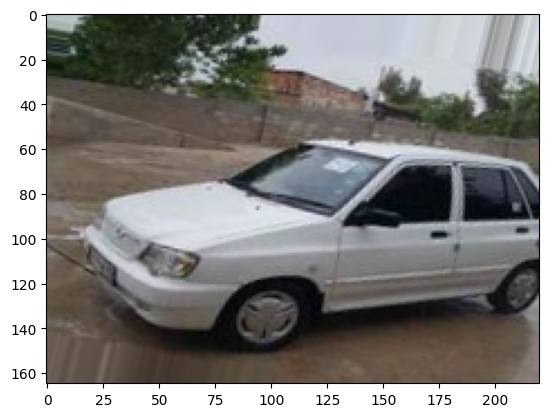

Tiba2


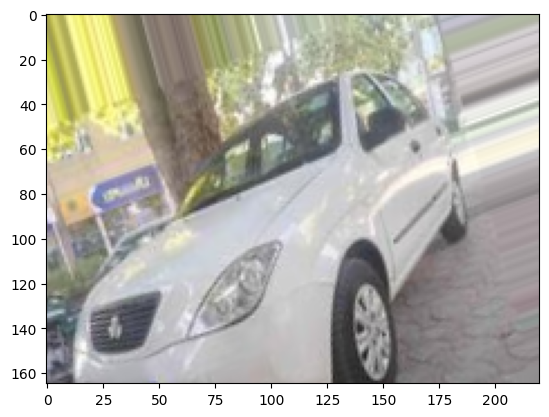

Peugeot-Pars


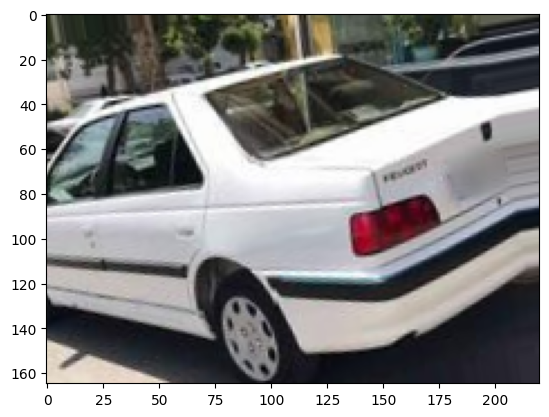

In [51]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

# Models:

## AlexNet

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    Adam = optimizers.Adam(learning_rate=lr)#alternative'SGD'
    model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

# history of results (set to None when initializing a new mdoel)
history = None


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 activation_45 (Activation)  (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_44 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 17, 17, 256)       2973952   
                                                                 
 activation_46 (Activation)  (None, 17, 17, 256)      

# Train

In [48]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 20  # sets number of epochs

try:
    h = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


# Save trained model and history
problemname = 'AlexNet-IranCarsClassification-20ep'
savemodel(model,problemname)
savehistory(h,problemname)

Epoch 1/20
40/40 [==============================] - 266s 7s/step - loss: 3.8077 - accuracy: 0.1163 - val_loss: 3.2320 - val_accuracy: 0.0658
Epoch 2/20
40/40 [==============================] - 404s 10s/step - loss: 3.6900 - accuracy: 0.1376 - val_loss: 3.2708 - val_accuracy: 0.0624
Epoch 3/20
40/40 [==============================] - 429s 11s/step - loss: 3.6576 - accuracy: 0.1569 - val_loss: 3.3005 - val_accuracy: 0.0719
Epoch 4/20
40/40 [==============================] - 443s 11s/step - loss: 3.5753 - accuracy: 0.1562 - val_loss: 3.3563 - val_accuracy: 0.0611
Epoch 5/20
40/40 [==============================] - 400s 10s/step - loss: 3.5449 - accuracy: 0.1577 - val_loss: 3.3490 - val_accuracy: 0.0638
Epoch 6/20
40/40 [==============================] - 448s 11s/step - loss: 3.4677 - accuracy: 0.1719 - val_loss: 3.2948 - val_accuracy: 0.0604
Epoch 7/20
40/40 [==============================] - 450s 11s/step - loss: 3.3959 - accuracy: 0.1778 - val_loss: 3.3503 - val_accuracy: 0.0604
Epoch 8

# Evaluate the model

### Accuracy on test set

In [159]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)


Found 1474 images belonging to 13 classes.
24/24 [==============================] - 35s 1s/step - loss: 3.2025 - accuracy: 0.0624
Test loss: 3.202535
Test accuracy: 0.062415


### Precision, recall, F-score

In [49]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3, zero_division=1))

Found 1474 images belonging to 13 classes.
24/24 [==============================] - 31s 1s/step
               precision    recall  f1-score   support

   Mazda-2000      0.387     0.130     0.195        92
Nissan-Zamiad      0.951     0.865     0.906        89
  Peugeot-206      0.149     0.084     0.108       119
 Peugeot-207i      0.196     0.348     0.251       112
  Peugeot-405      0.306     0.169     0.217        89
 Peugeot-Pars      0.393     0.196     0.262       112
       Peykan      0.326     0.365     0.344       115
    Pride-111      0.312     0.192     0.238       130
    Pride-131      0.246     0.283     0.263       113
         Quik      0.236     0.342     0.280       152
  Renault-L90      0.225     0.092     0.130        98
       Samand      0.292     0.055     0.093       127
        Tiba2      0.177     0.516     0.263       126

     accuracy                          0.276      1474
    macro avg      0.323     0.280     0.273      1474
 weighted avg      0.3

### Confusion matrix analysis

In [50]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

Found 1474 images belonging to 13 classes.
24/24 [==============================] - 31s 1s/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Pride-111        ->  Tiba2             	56 	3.80 % 
Quik             ->  Tiba2             	46 	3.12 % 
Peugeot-207i     ->  Quik              	38 	2.58 % 
Peykan           ->  Tiba2             	37 	2.51 % 
Pride-131        ->  Tiba2             	35 	2.37 % 
Samand           ->  Quik              	24 	1.63 % 
Quik             ->  Peugeot-207i      	24 	1.63 % 
Renault-L90      ->  Tiba2             	23 	1.56 % 
Mazda-2000       ->  Tiba2             	22 	1.49 % 
Peugeot-206      ->  Peugeot-207i      	22 	1.49 % 
Samand           ->  Peugeot-207i      	22 	1.49 % 
Peugeot-405      ->  Tiba2             	21 	1.42 % 
Peugeot-206      ->  Tiba2             	21 	1.42 % 
Peugeot-Pars     ->  Peugeot-207i      	20 	1.36 % 
Pride-131        ->  Peykan            	20 	1.36 % 
Ti


History loaded from file D:\machine learning\Iran-Cars\iran-used-cars-dataset\split/results/AlexNet-IranCarsClassification-20ep.hist



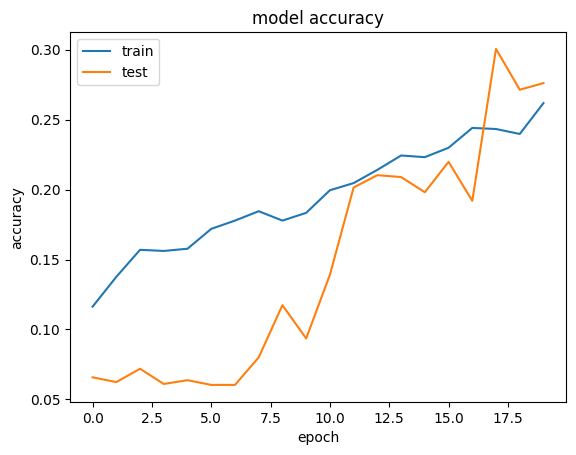

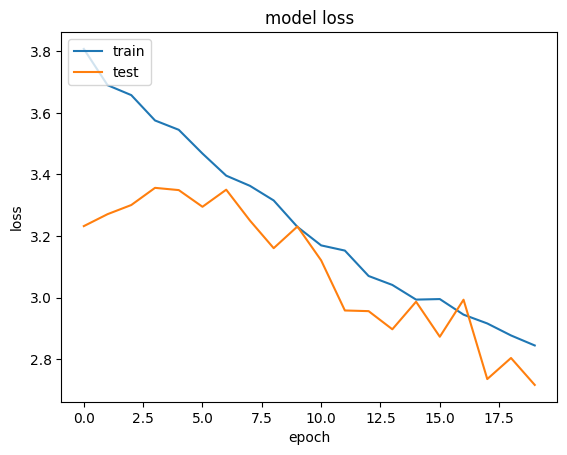

In [54]:
import matplotlib.pyplot as plt

histories = loadhistory('AlexNet-IranCarsClassification-20ep')
# summarize history for accuracy
plt.plot(histories['accuracy'])
plt.plot(histories['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histories['loss'])
plt.plot(histories['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Load base VGG16 model

Load VGG16 model pre-trained with ImageNet


In [58]:
# Load VGG16 model 
# init_weights='imagenet' if you want to use the pretrained model
def load_vgg16_features(input_shape, init_weights='imagenet'):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load VGG16 model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = tf.keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")

    optimizer = 'adam' #alternative 'sgd'

    feature_extractor.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()


Model: "vgg16_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 118, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 118, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 118, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 59, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 59, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 59, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 29, 56, 128)    

## VGG16-TransferNet

Transfer learning from VGG16 trained on ImageNet

In [59]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(200, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)
    
    # add a Dense layer
    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    # add the final output layer
    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = tf.keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model



# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

Model: "transferNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 118, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 118, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 118, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 59, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 59, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 59, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 29, 56, 128)       

### Train VGG16

In [60]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 20
try:
    transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


# Save trained model and history
problemname = 'VGG16-transfer-10ep_NEW'
savemodel(transfer_model,problemname)
savehistory(transfer_history,problemname)


Epoch 1/20
40/40 [==============================] - 1328s 33s/step - loss: 2.4870 - accuracy: 0.2307 - val_loss: 5.4105 - val_accuracy: 0.1832
Epoch 2/20
40/40 [==============================] - 1308s 33s/step - loss: 1.8342 - accuracy: 0.3750 - val_loss: 3.3985 - val_accuracy: 0.2883
Epoch 3/20
40/40 [==============================] - 1273s 32s/step - loss: 1.5465 - accuracy: 0.4779 - val_loss: 2.0622 - val_accuracy: 0.4240
Epoch 4/20
40/40 [==============================] - 1303s 33s/step - loss: 1.3628 - accuracy: 0.5465 - val_loss: 1.4851 - val_accuracy: 0.5346
Epoch 5/20
40/40 [==============================] - 1294s 33s/step - loss: 1.2160 - accuracy: 0.5789 - val_loss: 1.3158 - val_accuracy: 0.5753
Epoch 6/20
40/40 [==============================] - 1276s 32s/step - loss: 1.1158 - accuracy: 0.6155 - val_loss: 0.8658 - val_accuracy: 0.6988
Epoch 7/20
40/40 [==============================] - 1252s 32s/step - loss: 1.0452 - accuracy: 0.6388 - val_loss: 0.8628 - val_accuracy: 0.7022

## 3.4 Evaluate the model

### 3.4.1 Accuracy on test set


History loaded from file D:\machine learning\Iran-Cars\iran-used-cars-dataset\split/results/VGG16-transfer-IranCarsClassification-20ep.hist



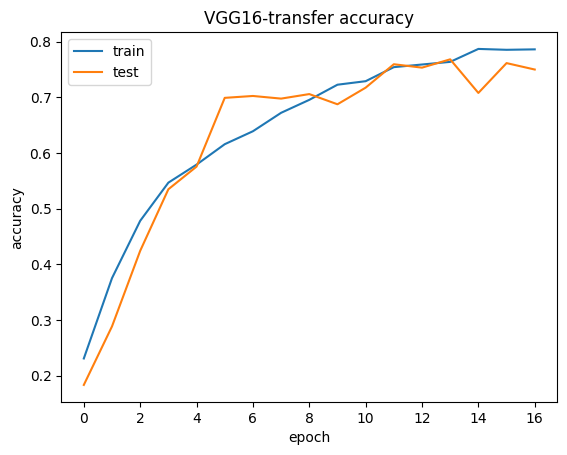

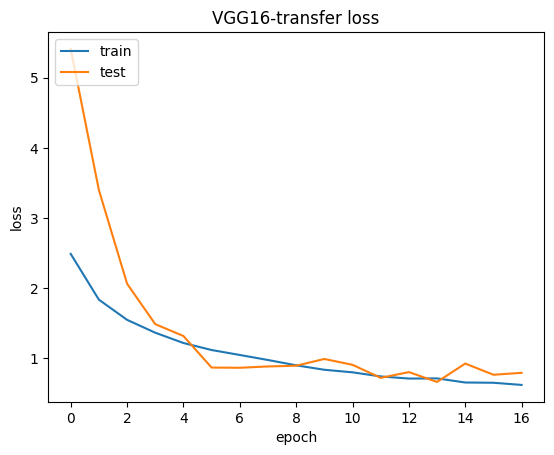

In [61]:

import matplotlib.pyplot as plt

histories = loadhistory('VGG16-transfer-IranCarsClassification-20ep')


# summarize history for accuracy

plt.plot(histories['accuracy'])
plt.plot(histories['val_accuracy'])
plt.title('VGG16-transfer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(histories['loss'])
plt.plot(histories['val_loss'])
plt.title('VGG16-transfer loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### 3.4.2 Precision, recall, F-score

In [62]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

#model = loadmodel('VGG16-transfer-IranCarsClassification-20ep')
model = keras.models.load_model(r"D:\machine learning\Iran-Cars\iran-used-cars-dataset\split\models\VGG16-transfer-IranCarsClassification-20ep.h5")
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3, zero_division=1))

Found 1474 images belonging to 13 classes.
24/24 [==============================] - 282s 12s/step
               precision    recall  f1-score   support

   Mazda-2000      0.849     0.793     0.820        92
Nissan-Zamiad      0.989     0.966     0.977        89
  Peugeot-206      0.836     0.773     0.803       119
 Peugeot-207i      0.960     0.643     0.770       112
  Peugeot-405      0.488     0.708     0.578        89
 Peugeot-Pars      0.875     0.625     0.729       112
       Peykan      0.892     0.861     0.876       115
    Pride-111      0.729     0.785     0.756       130
    Pride-131      0.638     0.655     0.646       113
         Quik      0.851     0.829     0.840       152
  Renault-L90      0.838     0.684     0.753        98
       Samand      0.945     0.543     0.690       127
        Tiba2      0.469     0.889     0.614       126

     accuracy                          0.750      1474
    macro avg      0.797     0.750     0.758      1474
 weighted avg      0

### 3.4.3 Confusion matrix analysis

In [64]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

Found 1474 images belonging to 13 classes.
24/24 [==============================] - 307s 13s/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Peugeot-207i     ->  Tiba2             	26 	1.76 % 
Renault-L90      ->  Tiba2             	24 	1.63 % 
Quik             ->  Tiba2             	23 	1.56 % 
Pride-131        ->  Pride-111         	21 	1.42 % 
Peugeot-206      ->  Tiba2             	19 	1.29 % 
Pride-131        ->  Peugeot-405       	17 	1.15 % 
Pride-111        ->  Tiba2             	14 	0.95 % 
Peugeot-Pars     ->  Peugeot-405       	14 	0.95 % 
Samand           ->  Peugeot-405       	14 	0.95 % 
Samand           ->  Tiba2             	10 	0.68 % 
Pride-111        ->  Pride-131         	10 	0.68 % 
Tiba2            ->  Quik              	9 	0.61 % 
Peugeot-405      ->  Pride-131         	9 	0.61 % 
Mazda-2000       ->  Peykan            	8 	0.54 % 
Samand           ->  Pride-111         	8 	0.54 % 
Mazd

## VGG16-ShallowNet

Use VGG16 features trained on ImageNet as input for a simple classifier based on Shallow NN

In [129]:
# define a shallow neural net
def shallowNet(input_shape, num_classes):

    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
        layer.trainable = False

    # get the last tensor from the feature extractor
    output_extractor = feature_extractor.output
    
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)
    
    # add the final output layer
    dense = Dense(num_classes, activation='softmax')(flatten_norm)
    

    shallow_model = Model(inputs=input_t, outputs=dense, name="shallowNet")
    
    
    optimizer = 'adam' #alternative 'SGD'
    shallow_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return shallow_model


shallow_model = shallowNet(input_shape, num_classes)
shallow_model.summary()

Model: "shallowNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 118, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 118, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 118, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 59, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 59, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 59, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 29, 56, 128)       0

### Train ShallowNet

In [130]:
# train the shallow model
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 20
try:
    shallow_history = shallow_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

# Save trained model and history
problemname = 'VGG16-features-ShallowNN-ARGOS-10ep_NEW'
savemodel(shallow_model,problemname)
savehistory(shallow_history,problemname)

Epoch 1/20
40/40 [==============================] - 956s 24s/step - loss: 2.3091 - accuracy: 0.3198 - val_loss: 2.1937 - val_accuracy: 0.2157
Epoch 2/20
40/40 [==============================] - 1209s 30s/step - loss: 1.5769 - accuracy: 0.5234 - val_loss: 1.7611 - val_accuracy: 0.3786
Epoch 3/20
40/40 [==============================] - 1231s 31s/step - loss: 1.3146 - accuracy: 0.5875 - val_loss: 1.5510 - val_accuracy: 0.4830
Epoch 4/20
40/40 [==============================] - 1247s 31s/step - loss: 1.1805 - accuracy: 0.6356 - val_loss: 1.2763 - val_accuracy: 0.5841
Epoch 5/20
40/40 [==============================] - 1150s 29s/step - loss: 1.0754 - accuracy: 0.6636 - val_loss: 1.1932 - val_accuracy: 0.6011
Epoch 6/20
40/40 [==============================] - 1252s 32s/step - loss: 0.9798 - accuracy: 0.6893 - val_loss: 1.1323 - val_accuracy: 0.6187
Epoch 7/20
40/40 [==============================] - 1204s 30s/step - loss: 0.9922 - accuracy: 0.6771 - val_loss: 1.1023 - val_accuracy: 0.6309


# 3.7 Evaluate the model

### 3.7.1 Accuracy on test set


History loaded from file D:\machine learning\Iran-Cars\iran-used-cars-dataset\split/results/VGG16-features-ShallowNN-IranCarsClassification-20ep.hist



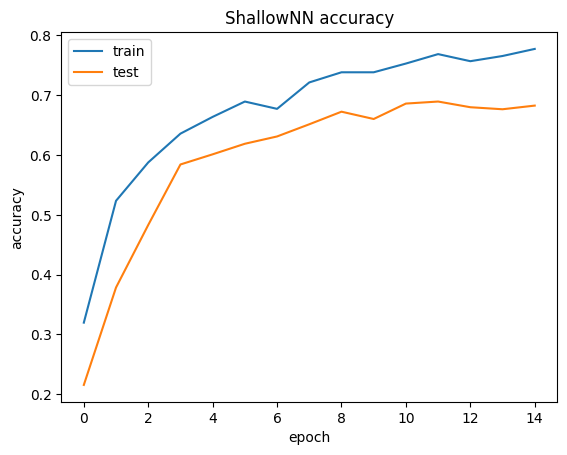

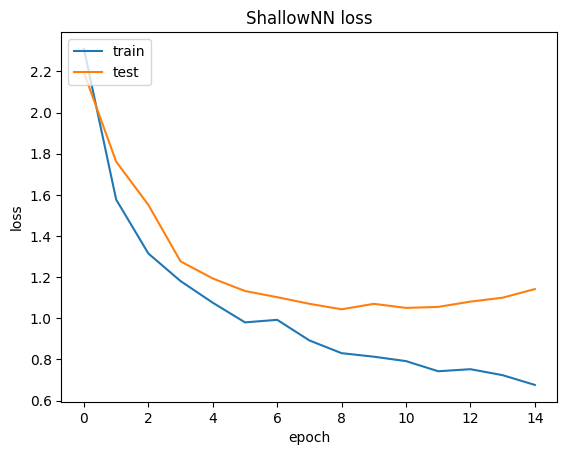

In [36]:

import matplotlib.pyplot as plt

histories = loadhistory('VGG16-features-ShallowNN-IranCarsClassification-20ep')


# summarize history for accuracy

plt.plot(histories['accuracy'])
plt.plot(histories['val_accuracy'])
plt.title('ShallowNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(histories['loss'])
plt.plot(histories['val_loss'])
plt.title('ShallowNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3.7.2 Precision, recall, F-score

In [38]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

#model = loadmodel('VGG16-transfer-IranCarsClassification-20ep')
model = keras.models.load_model(r"D:\machine learning\Iran-Cars\iran-used-cars-dataset\split\models\VGG16-features-ShallowNN-IranCarsClassification-20ep.h5")
val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3, zero_division=1))

Found 1474 images belonging to 13 classes.
24/24 [==============================] - 306s 13s/step
               precision    recall  f1-score   support

   Mazda-2000      0.747     0.772     0.759        92
Nissan-Zamiad      0.966     0.966     0.966        89
  Peugeot-206      0.589     0.782     0.671       119
 Peugeot-207i      0.832     0.705     0.763       112
  Peugeot-405      0.505     0.517     0.511        89
 Peugeot-Pars      0.662     0.438     0.527       112
       Peykan      0.832     0.730     0.778       115
    Pride-111      0.661     0.646     0.654       130
    Pride-131      0.447     0.637     0.526       113
         Quik      0.849     0.776     0.811       152
  Renault-L90      0.733     0.673     0.702        98
       Samand      0.617     0.520     0.564       127
        Tiba2      0.626     0.730     0.674       126

     accuracy                          0.682      1474
    macro avg      0.697     0.684     0.685      1474
 weighted avg      0

### 3.7.3 Confusion matrix analysis

In [39]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

Found 1474 images belonging to 13 classes.
24/24 [==============================] - 318s 13s/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Pride-111        ->  Pride-131         	26 	1.76 % 
Peugeot-207i     ->  Peugeot-206       	17 	1.15 % 
Peugeot-Pars     ->  Samand            	15 	1.02 % 
Samand           ->  Peugeot-Pars      	15 	1.02 % 
Peykan           ->  Pride-131         	14 	0.95 % 
Pride-131        ->  Pride-111         	14 	0.95 % 
Peugeot-Pars     ->  Pride-131         	14 	0.95 % 
Quik             ->  Tiba2             	14 	0.95 % 
Peugeot-Pars     ->  Peugeot-405       	11 	0.75 % 
Tiba2            ->  Peugeot-206       	11 	0.75 % 
Peugeot-206      ->  Tiba2             	10 	0.68 % 
Samand           ->  Pride-131         	10 	0.68 % 
Peugeot-405      ->  Pride-131         	10 	0.68 % 
Samand           ->  Peugeot-206       	9 	0.61 % 
Samand           ->  Peugeot-405       	9 	0.61 % 
Ti

## VGG16-SVM

Use VGG16 features to train an SVM model.

In [9]:
# Load VGG16 pre-trained on Image Net
vgg16feat_model = load_vgg16_features(input_shape, init_weights='imagenet')


In [11]:
def rescale(x):
  x = x / 255.
  return x

# image flow of training samples from directory (without augmentation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainingset,
  image_size=(118, 224),
  label_mode='categorical',
  batch_size=batch_size,
  shuffle=False)

print('Creating cache for training images... it takes several minutes....')
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# re-scale images to 0-1 range
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
train_ds = train_ds.repeat(1)

# extract training features
x_feat = vgg16feat_model.predict(train_ds)

# global average pool on training features
x_feat_resh = np.mean(x_feat, axis=(1,2))
#x_feat_resh = np.reshape(x_feat, (x_feat.shape[0],-1))

# extract testing features
x_feat_test = vgg16feat_model.predict(test_generator)

# global average pool on testing features
#x_feat_test_resh = np.reshape(x_feat_test, (x_feat_test.shape[0],-1))
x_feat_test_resh = np.mean(x_feat_test, axis=(1,2))

# get the training/test labels
y_train = []
y_test = []

# image flow of testing samples from directory 
# we can't directly use the previously instantiated testing flow-from_diretory because of bug
# loops indefinetely if used with for loop (https://github.com/keras-team/keras-preprocessing/issues/45)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testset,
  image_size=(118, 224),
  label_mode='categorical',
  batch_size=batch_size,
  shuffle=False)

print('Creating cache for testing images... it takes several minutes....')
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# re-scale images to 0-1 range
test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.repeat(1)

# get the training/testing labels (sklearn format)
y_train = [y_b for _, y_b in train_ds]
y_test = [y_b for _, y_b in test_ds]

y_train = np.concatenate(y_train, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)


Found 2600 files belonging to 13 classes.
Creating cache for training images... it takes several minutes....
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
24/24 [==============================] - 342s 14s/step
Found 1474 files belonging to 13 classes.
Creating cache for testing images... it takes several minutes....


## Train and evaluate SVM model

In [12]:
from sklearn import svm

kernel_name  = 'linear' # 'linear', 'poly', 'rbf', 'sigmoid'
C = 0.9

classifier = svm.SVC(C=C, kernel=kernel_name, degree=3, gamma="scale")
classifier.fit(x_feat_resh,y_train)


problemname = 'VGG16-features-ShallowNN-ARGOS-10ep_NEW'

svm_acc = classifier.score(x_feat_test_resh, y_test)    
print("Accuracy %.3f" %svm_acc)

Accuracy 0.619
